# Environment

In [1]:
# !pip install tensorflow==2.3.1   #2.3.0

In [2]:
# !pip install --upgrade pip

In [18]:
# !pip uninstall tensorflow-gpu  #==2.3.1
# !pip install seaborn
# !pip install pymorphy2
# !pip install scikit-learn
!pip install tensorflow_addons
# !pip install spacy
# !pip install gensim
# !pip install nltk
# !pip install psutil
# !pip install psycopg2
# !pip install keras==2.3.1

Looking in indexes: http://mirror.ca.sbrf.ru/pypi/simple
You should consider upgrading via the '/opt/app-root/bin/python3.6 -m pip install --upgrade pip' command.


In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')  #darkgrid

In [21]:
# Basic
import os
import re
import sys
import glob
import gc
import random
import pickle
import psutil
import psycopg2
import datetime
import numpy as np
import pandas as pd

from pathlib import Path
from pprint import pprint
from collections import Counter, namedtuple
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict, namedtuple, deque, Counter
from typing import (List, Dict, Any, NoReturn, 
                    Tuple, Optional, Union)
from tqdm import tqdm
from datetime import datetime as dt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [22]:
# from tensorflow.keras import backend as K

In [23]:
# Keras NN
%load_ext tensorboard
!rm -rf ./logs/

from tensorflow import keras
# import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, schedules
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import (Dense, Embedding, LSTM, BatchNormalization, concatenate, Bidirectional, 
                          Input, Lambda, MaxPooling1D, AveragePooling1D, Flatten, Dropout, Layer, 
                          GlobalAveragePooling1D, GlobalMaxPooling1D, Masking, TimeDistributed, 
                          Multiply, Softmax, BatchNormalization, LayerNormalization, Concatenate, Reshape, Conv1D)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [24]:
# Keras Addons
import tensorflow_addons as tfa
from tensorflow_addons.losses import metric_learning
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike

In [25]:
# Clustering
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, cut_tree
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Classification
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (balanced_accuracy_score, accuracy_score, 
                             classification_report, confusion_matrix)

# W2V
import spacy
import pymorphy2
from gensim.models import KeyedVectors
from gensim.models.phrases import Phrases
from nltk.stem.snowball import SnowballStemmer

In [26]:
import logging
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO)

In [27]:
import tensorflow as tf
tf.__version__

'2.3.1'

## Define paths

In [28]:
from tensorflow.python.client import device_lib

In [29]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
device_lib.list_local_devices()

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:GPU:0']


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3619234566779545703,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2205508303870265760
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17510982958214408676
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15685569792
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12810166627085241792
 physical_device_desc: "device: 0, name: NVIDIA Tesla P100-PCIE-16GB, pci bus id: 0000:00:05.0, compute capability: 6.0"]

In [30]:
print(f"CPU count: {psutil.cpu_count()}")
print(f"CPU utilization: {psutil.cpu_percent()}%")
mem_stats = psutil.virtual_memory()
print(f"Memory total: {mem_stats.total / 1048576} MB.")
print(f"Memory available: {mem_stats.available / 1048576} MB.")
print(f"Memory used: {mem_stats.used / 1048576} MB.")

CPU count: 32
CPU utilization: 1.0%
Memory total: 235609.53515625 MB.
Memory available: 227898.16015625 MB.
Memory used: 6824.5625 MB.


In [31]:
print("Num GPUs Available: ", tf.test.gpu_device_name())
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_cuda())

with tf.device('/device:GPU:0'):
    print(tf.math.add(1.0, 2.0))

Num GPUs Available:  /device:GPU:0
True
True
tf.Tensor(3.0, shape=(), dtype=float32)


In [32]:
BASE_DIR = Path("..")
DATA_DIR  = BASE_DIR / "data"
MODEL_DIR  = BASE_DIR / "models"
CHKP_DIR = MODEL_DIR / "chkp_dir"

## Load data

In [33]:
def load_data(start_date: str, end_date: str, is_prediction: Tuple[bool], 
              maxnum: int=1e6):
    
    print(f"Creating connection to DB...")
    connection = psycopg2.connect("dbname='{}' user='{}' host='{}' password='{}' port = {}".format(
        'pgarmat', 'postgres', 'tklis-sm0000002.vm.mos.cloud.sbrf.ru', 'ZxqZo8lX', '5432'))
    print(f"Connection created.")
    
    with connection.cursor() as cursor:
        try:
            cursor.execute(f"""
                select
                req_num, 
                msg, 
                incident,
                incident_probability,
                req_reg_datetime, 
                product, 
                subject,
                s_subject, 
                subproduct,
                grp, 
                channel
                from ds70.request_messages
                where 1=1
                and is_prediction in {is_prediction}
                and req_reg_datetime between '{start_date}' and '{end_date}'
                limit {maxnum};""")
            requests = cursor.fetchall()
        except Exception as ee:
            print(ee)
            connection.rollback()
            
        data = pd.DataFrame(requests, columns=["req_num",
                                               "msg",
                                               "incident",
                                               "incident_probability",
                                               "req_reg_datetime",
                                               "product",
                                               "subject",
                                               "s_subject",
                                               "subproduct",
                                               "grp",
                                               "channel"])
        print(f"Loaded data shape: {data.shape} and size: {sys.getsizeof(data) / 1048576} MB.")
        return data

In [34]:
def load_vectors_data(start_date: str, end_date: str, 
                      is_prediction: Tuple[bool], relevance_date: str,
                      maxnum: int=1e6):
    
    print(f"Creating connection to DB...")
    connection = psycopg2.connect("dbname='{}' user='{}' host='{}' password='{}' port = {}".format(
        'pgarmat', 'postgres', 'tklis-sm0000002.vm.mos.cloud.sbrf.ru', 'ZxqZo8lX', '5432'))
    print(f"Connection created.")
    
    with connection.cursor() as cursor:
        try:
            cursor.execute(f"""
                select
                req_num, 
                req_reg_datetime, 
                msg,
                product, 
                subject,
                s_subject, 
                subproduct,
                client_msg_vector,
                vector_update_datetime
                from ds70.request_messages
                where 1=1
                and client_msg_vector is not null
                and vector_update_datetime >= '{relevance_date}'
                and is_prediction in {is_prediction}
                and req_reg_datetime between '{start_date}' and '{end_date}'
                limit {maxnum};""")
            requests = cursor.fetchall()
        except Exception as ee:
            print(ee)
            connection.rollback()
            
        data = pd.DataFrame(requests, columns=["req_num",
                                               "req_reg_datetime",
                                               "msg",
                                               "product",
                                               "subject",
                                               "s_subject",
                                               "subproduct",
                                               "client_msg_vector",
                                               "vector_update_datetime"])
        print(f"Loaded data shape: {data.shape} and size: {sys.getsizeof(data) / 1048576} MB.")
        return data

In [ ]:
df = load_vectors_data(start_date='2021-01-01 0:00:01', end_date='2021-01-10 23:59:59', is_prediction=(True, False),
                       relevance_date='2021-07-12 0:00:01', maxnum=600_000)
# test_df = load_vectors_data(start_date='2021-03-01 0:00:01', end_date='2021-03-30 23:59:59', is_prediction=(True, False),
#                           maxnum=200_000)

Creating connection to DB...
Connection created.


In [196]:
df.head()

,req_num,req_reg_datetime,msg,product,subject,s_subject,subproduct,client_msg_vector,vector_update_datetime,label_name
0,2101040984722400,2021-01-04 11:30:40,operator: #ФИО здравствуйте client:добрый ден...,Банковская карта,Выпуск/перевыпуск/доставка карты,Статус выпуска карты,Дебетовая карта,"[99.0, 63.0, 148.0, 1589.0, 1.0, 1160.0, 1.0, ...",12:50:28.455658,Банковская карта : Статус выпуска карты
1,2101040980205000,2021-01-04 10:28:46,operator:нет #ФИО здравствуйте client:здравс...,Автоплатеж,Проведение платежа,"Разъяснение сроков, условий исполнения","ЖКХ (коммунальные услуги, капитальный ремонт)","[212.0, 69.0, 172.0, 89.0, 18.0, 17.0, 7.0, 22...",12:50:28.455658,"Автоплатеж : Разъяснение сроков, условий испол..."
2,2101040979369900,2021-01-04 10:16:18,operator: #ФИО здравствуйте client:здравствуй...,Банковская карта,На счет Сбербанка/стороннего банка,Розыск перевода - подтверждение/статус,Перевод (от ФЛ к ФЛ),"[89.0, 1649.0, 2117.0, 471.0, 37.0, 78.0, 23.0...",12:50:28.455658,Банковская карта : Розыск перевода - подтвержд...
3,2101050067177200,2021-01-05 16:54:45,operator: #ФИО здравствуйте client:здравствуй...,Банковская карта,Вопросы по совершенной покупке,Подтверждение/статус операции/уточнение факта ...,Дебетовая карта,"[18.0, 7487.0, 30.0, 1.0, 93.0, 310.0, 839.0, ...",12:50:28.455658,Банковская карта : Подтверждение/статус операц...
4,2101100314341200,2021-01-10 10:28:54,operator: #ФИО здравствуйте client:здравствуй...,Автоплатеж,"Условия, комиссии и статус","Комиссии, сроки, условия, статус и параметры у...","ЖКХ (коммунальные услуги, капитальный ремонт)","[2760.0, 25368.0, 209.0, 62.0, 36.0, 1877.0, 1...",12:50:28.455658,"Автоплатеж : Комиссии, сроки, условия, статус ..."


In [16]:
df.client_msg_vector.isna().value_counts()

NameError: name 'df' is not defined

In [20]:
df.head()

,req_num,req_reg_datetime,msg,product,subject,s_subject,subproduct,client_msg_vector,vector_update_datetime
0,2101040984722400,2021-01-04 11:30:40,operator: #ФИО здравствуйте client:добрый ден...,Банковская карта,Выпуск/перевыпуск/доставка карты,Статус выпуска карты,Дебетовая карта,"[99.0, 63.0, 148.0, 1589.0, 1.0, 1160.0, 1.0, ...",12:50:28.455658
1,2101040980205000,2021-01-04 10:28:46,operator:нет #ФИО здравствуйте client:здравс...,Автоплатеж,Проведение платежа,"Разъяснение сроков, условий исполнения","ЖКХ (коммунальные услуги, капитальный ремонт)","[212.0, 69.0, 172.0, 89.0, 18.0, 17.0, 7.0, 22...",12:50:28.455658
2,2101040979369900,2021-01-04 10:16:18,operator: #ФИО здравствуйте client:здравствуй...,Банковская карта,На счет Сбербанка/стороннего банка,Розыск перевода - подтверждение/статус,Перевод (от ФЛ к ФЛ),"[89.0, 1649.0, 2117.0, 471.0, 37.0, 78.0, 23.0...",12:50:28.455658
3,2101050067177200,2021-01-05 16:54:45,operator: #ФИО здравствуйте client:здравствуй...,Банковская карта,Вопросы по совершенной покупке,Подтверждение/статус операции/уточнение факта ...,Дебетовая карта,"[18.0, 7487.0, 30.0, 1.0, 93.0, 310.0, 839.0, ...",12:50:28.455658
4,2101100314341200,2021-01-10 10:28:54,operator: #ФИО здравствуйте client:здравствуй...,Автоплатеж,"Условия, комиссии и статус","Комиссии, сроки, условия, статус и параметры у...","ЖКХ (коммунальные услуги, капитальный ремонт)","[2760.0, 25368.0, 209.0, 62.0, 36.0, 1877.0, 1...",12:50:28.455658


## Configure target values

In [21]:
df['label_name'] = df['product'] + " : " + df['s_subject']
print(df['label_name'].nunique())

815


### Select most frequent classes

In [22]:
freq_labels = df.label_name.value_counts().reset_index().rename({'index': "label_name_name"}, axis=1)
freq_labels.describe()

,label_name
count,815.000000
mean,586.186503
std,2877.506090
min,1.000000
25%,3.000000
50%,20.000000
75%,159.000000
max,52111.000000


In [23]:
freq_labels.head(10)

,label_name_name,label_name
0,Банковская карта : Баланс/операции по карте,52111
1,"Банковская карта : Комиссии, сроки, условия",37751
2,Удобство/Качество обслуживания : Реквизиты ВСП...,21036
3,Банковская карта : Тарифы/лимиты/ условия пред...,20338
4,Банковская карта : Досрочный перевыпуск дебето...,16254
5,Банковская карта : Кража или утеря,13399
6,Банковская карта : Сверхлимитная операция,12885
7,Банковская карта : Справочная информация (срок...,12448
8,Банковская карта : Статус БК/Порядок предостав...,10271
9,Банковская карта : БК заблокирована для провер...,9703


In [24]:
# Take only most frequent subjects
n_freq_labels = 50

freq_labels = freq_labels.loc[freq_labels.label_name > n_freq_labels]
print("Lables left: ", freq_labels.shape[0])
freq_labels_list = freq_labels.label_name_name.to_list()

df = df.loc[df.label_name.isin(freq_labels_list)]
print(f"Left {len(df)} requests.")

Lables left:  312
Left 472524 requests.


### Train/test split

In [25]:
train_df, test_df = train_test_split(df, test_size=0.3, 
                                     random_state=11, stratify=df.label_name)
test_df, val_df = train_test_split(test_df, test_size=0.4, 
                                   random_state=11, stratify=test_df.label_name)
print(f"Train data: {train_df.shape[0]} test data: {test_df.shape[0]}, val data: {val_df.shape[0]}")

Train data: 330766 test data: 85054, val data: 56704


## Configure preprocessing

In [ ]:
def file_opener(filename: str) -> str:
    with open(filename, 'rt', encoding='utf-8-sig') as src:
        file = src.read()
    return "|".join([x for x in file.split('\n') if x])


class DataPreprocessor:

    text_features = ['subject', 's_subject', 'product',
                     'subproduct', 'grp', 'channel', 'msg']

    def __init__(self, only_unique: bool=True, intro_words_path: str = './lists'):
        self.__morph = pymorphy2.MorphAnalyzer()
        self.__nlp = spacy.blank('ru')
        self.__only_unique = only_unique
        self.__intro_words = file_opener(os.path.join(intro_words_path, 'intro.txt'))
        self.__nltk_stopwords = file_opener(os.path.join(intro_words_path, 'NLTK_stopwords.txt')).split("|")

    def get_stopwords(self):
        """ 
        Check intro-words list.
        """
        return self.__nltk_stopwords

    def get_intro_words(self):
        """ 
        Check intro-words list.
        """
        return self.__intro_words

    def _reformat_datetime(self, dt: datetime) -> str:
        """ Reformat datetime and convert to string """
        return dt.strftime("%Y-%m-%d %H-%M-%S")
    
    def _process_text(self, text: str):
        """ 
        Process single text and return list of tokens.
        """
        if pd.isna(text):
            return []
        text = [str(token).lower()
                for token in self.__nlp.make_doc(text)
                if (token and token.is_alpha and len(str(token.text)) > 2 and ~token.is_stop)]
        clean_text = []
        for token in text:
            token = self.__morph.parse(str(token).lower())[0]
            if token.normal_form not in self.__nltk_stopwords:
                clean_text.append(token.normal_form)
        if self.__only_unique:
            clean_text = list(set(clean_text))
        return clean_text
    

    def process_texts(self, texts: List[str]):
        """ 
        Process list of texts and return list of lists of tokens.
        """
        return [self._process_text(text) for text in tqdm(texts)]


    def process(self, data: pd.DataFrame,
                features_cols: Optional[List[str]] = None, copy: bool=True) -> pd.DataFrame:
        """
        Preprocess text for language modelling.
         - clean introduction words, numbers and small prefixes;
         - tokenize and lemmatize texts;
        """
        print("[INFO] Text processing...")
        if not features_cols:
            features_cols = self.text_features

        for col_name in features_cols:
            print(f"[INFO] Process '{col_name}' column...")
            data_processed = self.process_texts(data[col_name].fillna("").to_list())
            if not copy:
                data[col_name] = data_processed
            else:
                data[col_name + "_proc"] = data_processed

        print("[INFO] Text finished.")
        return data

In [143]:
class DataVectorizer:
 
    def __init__(self, phrase_model: Phrases = None,
                 w2v_vectorizer: Optional[KeyedVectors] = None):
        """
        Need to load pre-trained models from files.
        """
        self._w2v = w2v_vectorizer
        self._phrase_model = phrase_model
        self._vocab_size, self._embedding_size = self._w2v.vectors.shape
 
       
    @classmethod
    def load(cls, save_path: str, phrases_fn: str, w2v_fn: str) -> object:
        """
        Load pre-trained models from files and init.
        """
        phrase_model = Phrases.load(os.path.join(save_path, phrases_fn))
        w2v_vectorizer = KeyedVectors.load_word2vec_format(os.path.join(save_path, w2v_fn), binary=False)
        return cls(phrase_model=phrase_model,
                   w2v_vectorizer=w2v_vectorizer)
   
    
    def _word2id(self, token_seq: List[List[str]], max_seq_len: int):
        """
        Convert token to id in W2V vocabulary.
        """
        id_seq = [[self._w2v.key_to_index[tok] + 1 for tok in doc if self._w2v.has_index_for(tok)]
                  for doc in tqdm(token_seq)]
#         id_seq = pad_sequences(id_seq, value=0, maxlen=max_seq_len, padding='post', truncating='post')
        return id_seq
    
    
    def _id2word(self, ids_seq: List[int], padding_value: int):
        """
        Convert id to token with W2V vocabulary.
        """
        if len(ids_seq) == 0:
            tokens_seq = []
        else:
            tokens_seq = [self._w2v.index_to_key[int(tok_id - 1)] for tok_id in ids_seq
                           if (self._vocab_size >= (tok_id - 1)) and (tok_id != padding_value)]
        return tokens_seq
 
   
    def vectorize(self, data: pd.DataFrame, text_col: str, 
                  max_seq_len: int=150, min_seq_len: int=15) -> pd.DataFrame:
        """
        Vectorize data:
            - encode words as ids
            - reduce dimensions
        """
        text_data = data[text_col].to_list()
        text_data = [self._phrase_model[d] if len(d) > 0 else np.zeros((max_seq_len,)) for d in text_data]
        text_data = self._word2id(text_data, max_seq_len)
        data['vector'] = [vec for i, vec in enumerate(text_data)]
        data_indexes = [i for i, vec in enumerate(text_data) if np.count_nonzero(vec) > min_seq_len]
        return data.iloc[data_indexes]
    
    def devectorize(self, index_vectors: np.ndarray, padding_value: int=0) -> np.ndarray:
        """
        De-vectorize data:
            - decode indexes to words
            - concat to lists of tokens and return
        """
        text_data = [self._id2word(index_vectors, padding_value) for index_vector in index_vectors]
        return text_data
    
    def devectorize_df(self, data: pd.DataFrame, index_vectors_col: str, 
                       tokens_col: str, padding_value: int=0) -> np.ndarray:
        """
        De-vectorize dataframe with respect to indexes:
            - decode indexes to words
            - concat to lists of tokens and return
        """
        data[tokens_col] = data[index_vectors_col].apply(lambda x: self._id2word(x, padding_value))
        return data
   
    def get_vectors(self):
        return self._w2v.vectors

In [144]:
# processor = DataPreprocessor(intro_words_path=str(BASE_DIR / 'lists'))

In [145]:
dvect = DataVectorizer.load(str(MODEL_DIR), phrases_fn="phrases_gensim_lemmas_12_07_2021.pkl",
                           w2v_fn='word2vec_gensim_lemmas_12_07_2021')

2021-07-15 11:15:32 - loading Phrases object from ../models/phrases_gensim_lemmas_12_07_2021.pkl
2021-07-15 11:15:35 - Phrases lifecycle event {'fname': '../models/phrases_gensim_lemmas_12_07_2021.pkl', 'datetime': '2021-07-15T11:15:35.622037', 'gensim': '4.0.1', 'python': '3.6.8 (default, Aug 18 2020, 08:33:21) \n[GCC 8.3.1 20191121 (Red Hat 8.3.1-5)]', 'platform': 'Linux-3.10.0-1160.31.1.el7.x86_64-x86_64-with-redhat-8.3-Ootpa', 'event': 'loaded'}
2021-07-15 11:15:35 - older version of Phrases loaded without common_terms attribute, setting connector_words to an empty set
2021-07-15 11:15:35 - loading projection weights from ../models/word2vec_gensim_lemmas_12_07_2021
2021-07-15 11:15:57 - KeyedVectors lifecycle event {'msg': 'loaded (95552, 200) matrix of type float32 from ../models/word2vec_gensim_lemmas_12_07_2021', 'binary': False, 'encoding': 'utf8', 'datetime': '2021-07-15T11:15:57.676654', 'gensim': '4.0.1', 'python': '3.6.8 (default, Aug 18 2020, 08:33:21) \n[GCC 8.3.1 2019112

In [146]:
dvect._vocab_size

95552

In [148]:
# print(dvect._w2v.index_to_key )
# print(dvect._w2v.key_to_index)
ids = dvect._word2id([['карта', 'мочь', 'перевод', 'сбербанк', 'онлайн']], 6)
print(ids)
words = dvect._id2word(ids[0], 0)
print(words)

100%|██████████| 1/1 [00:00<00:00, 4837.72it/s]

[[1, 2, 21, 10, 125]]
['карта', 'мочь', 'перевод', 'сбербанк', 'онлайн']


### Make datasets for training

In [31]:
le = LabelEncoder().fit(train_df.label_name)
train_df['label'] = le.transform(train_df.label_name)
test_df['label'] = le.transform(test_df.label_name)
val_df['label'] = le.transform(val_df.label_name)

In [32]:
train_df.head()

,req_num,req_reg_datetime,msg,product,subject,s_subject,subproduct,client_msg_vector,vector_update_datetime,label_name,label
323897,2101070164160500,2021-01-07 13:43:46,operator: #ФИО здравствуйте operator:и вас с ...,Банковская карта,На карту Сбербанка,"Комиссии, сроки, условия",Перевод (от ФЛ к ФЛ),"[284.0, 99.0, 284.0, 7.0, 17.0, 39.0, 3331.0, ...",12:50:28.455658,"Банковская карта : Комиссии, сроки, условия",48
235754,2101040980953500,2021-01-04 10:39:27,operator:здравствуйте client:здравствуйте мне ...,Банковская карта,Предоставление информации,Статус БК/Порядок предоставления документов,Дебетовая карта,"[1.0, 61.0, 236.0, 153.0, 656.0, 41070.0, 165....",12:50:28.455658,Банковская карта : Статус БК/Порядок предостав...,100
130254,2101010873607100,2021-01-01 20:16:22,operator: #ФИО здравствуйте client:да здравст...,Сбербанк-Телеком,Приложение СберМобайл,Мобильное приложение 2.0,Сервисы самообслуживания,"[55.0, 33.0, 88709.0, 212.0, 26.0, 301.0, 5063...",12:50:28.455658,Сбербанк-Телеком : Мобильное приложение 2.0,265
400153,2101030957747100,2021-01-03 18:43:33,operator:здравствуйте client:здравствуйте а пе...,Банковская карта,За рубеж. Для выплаты наличными,"Комиссии, сроки, условия",Перевод (от ФЛ к ФЛ),"[21.0, 285.0, 481.0, 14.0, 186.0, 1.0, 9.0, 11...",12:50:28.455658,"Банковская карта : Комиссии, сроки, условия",48
87447,2101060117331600,2021-01-06 14:56:50,operator:меня зовут #ФИО здравствуйте client...,Банковская карта,Отказ в проведении операции,55/75 – Неверный ПИН или превышено количество ...,Дебетовая карта,"[555.0, 440.0, 63.0, 650.0, 26.0, 1643.0, 14.0...",12:50:28.455658,Банковская карта : 55/75 – Неверный ПИН или пр...,16


In [33]:
train_labels = train_df['label'].values
test_labels = test_df['label'].values
val_labels = val_df['label'].values

train_vectors = pad_sequences(train_df['client_msg_vector'].to_list(), value=0, maxlen=150, padding='post', truncating='post')
test_vectors = pad_sequences(test_df['client_msg_vector'].to_list(), value=0, maxlen=150, padding='post', truncating='post')
val_vectors = pad_sequences(val_df['client_msg_vector'].to_list(), value=0, maxlen=150, padding='post', truncating='post')

train_indexes = [i for i, vec in enumerate(train_vectors) if np.count_nonzero(vec) > 19]
test_indexes = [i for i, vec in enumerate(test_vectors) if np.count_nonzero(vec) > 19]
val_indexes = [i for i, vec in enumerate(val_vectors) if np.count_nonzero(vec) > 19]

train_vectors, train_labels = train_vectors[train_indexes], train_labels[train_indexes]
test_vectors, test_labels = test_vectors[test_indexes], test_labels[test_indexes]
val_vectors, val_labels = val_vectors[val_indexes], val_labels[val_indexes]

train_vectors = np.vstack(train_vectors)
test_vectors = np.vstack(test_vectors)
val_vectors = np.vstack(val_vectors)

In [34]:
train_vectors.shape

(313821, 150)

## Model utilities

In [35]:
def adj_rand_score(labels, embeddings):
    linkage_matrix = linkage(embeddings, metric='cosine', method='average')
    clusters = [i[0] for i in cut_tree(linkage_matrix, n_clusters=[labels.shape[1]])]
    return adjusted_rand_score(clusters, np.argmax(labels, axis=1))

def word2idx(word):
    return word2vec_model.wv.vocab[word].index + 1

def idx2word(idx):
    return word2vec_model.wv.index2word[idx-1]

## Loss functions

## Model architecture

In [36]:
class NNModel():
    
    def __init__(self, pretrained_weights: np.ndarray, input_length: int,
                 n_hidden_units: int, out_dims: int, vocab_size: int, 
                 embedding_size: int=300, dropout: float=0.5, 
                 pretrained=False, model_weights_path='./model.hdf5'):
        
        self.input_length = input_length
        self.pretrained_weights = pretrained_weights
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.n_hidden_units = n_hidden_units
        self.out_dims = out_dims
        self.dropout = dropout
        self.model, self.attention_model = self.create_network()
        if pretrained:
            self.load_pretrained(model_weights_path)
        
    def create_network(self):
        input_layer = Input((self.input_length,))
        embeddings = Embedding(input_dim=self.vocab_size + 1, output_dim=self.embedding_size,
                                    weights=[np.vstack((np.zeros((1, self.embedding_size), dtype=np.float32), 
                                                        self.pretrained_weights))],
                                    input_length=self.input_length, mask_zero=True, trainable=True)(input_layer)
        # Return [batch_size x n_timesteps x n_hidden_units]
        lstm = LSTM(self.n_hidden_units, dropout=self.dropout, return_sequences=True)(embeddings)
        lstm = BatchNormalization()(lstm)
        # Attention block
        # Returns single value for each timestamp
        attention = TimeDistributed(Dense(1))(lstm)
        softmax_attention = Softmax(axis=1)(attention)
        apply_attention = Multiply()([softmax_attention, lstm])
        avg_pooling = GlobalAveragePooling1D()(apply_attention)
#         max_pooling = GlobalMaxPooling1D()(apply_attention)
#         c = Concatenate()([avg_pooling, max_pooling])
#         c = BatchNormalization()(c)
        dense = Dense(self.out_dims, activation=None)(avg_pooling)
        output_layer = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense)
        att_model = Model(input_layer, [output_layer, softmax_attention])
        model = Model(input_layer, output_layer)
        return model, att_model
        
        
    def load_pretrained(self, model_weights_path: str):
        self.model.load_weights(model_weights_path)

In [37]:
model = NNModel(pretrained_weights=dvect.get_vectors(), input_length=150,
                n_hidden_units=128, out_dims=50, vocab_size=dvect._vocab_size, 
                embedding_size=dvect._embedding_size, dropout=0.6, 
                pretrained=False, model_weights_path=str(MODEL_DIR / "attention_lstm_50dim_13-07.h5"))

model.attention_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 200)     19110600    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 150, 128)     168448      embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 128)     512         lstm[0][0]                       
_______________________________________________________________________________________

# Train

In [38]:
CHKP_DIR

PosixPath('../models/chkp_dir')

In [39]:
os.path.exists(str(CHKP_DIR))

True

In [40]:
n_epochs = 50
patience = 3
batch_size = 128

!rm -rf ../models/chkp_dir/*
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [EarlyStopping(patience=patience, monitor='val_loss'),
            tf.keras.callbacks.ModelCheckpoint(filepath=str(CHKP_DIR / "checkpoint-{epoch}.h5"),
                save_weights_only=False,
                monitor='val_loss', mode='min',
                save_best_only=True),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)]

tclr = tfa.optimizers.Triangular2CyclicalLearningRate(
    initial_learning_rate=1e-4,
    maximal_learning_rate=1e-2,
    step_size=8 * int(len(train_df) / batch_size),
    scale_mode='cycle',
    name='TriangularCyclicalLearningRate'
)
with tf.device('GPU:0'):
    # lr_schedule = schedules.ExponentialDecay(initial_learning_rate=1.0e-3, decay_steps=5, decay_rate=0.3)
    model.model.compile(optimizer=Adam(learning_rate=tclr), loss=tfa.losses.TripletSemiHardLoss(margin=1.0))
    model.attention_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 200)     19110600    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 150, 128)     168448      embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 128)     512         lstm[0][0]                       
_______________________________________________________________________________________

In [41]:
with tf.device('GPU:0'):
    history = model.model.fit(x=train_vectors, y=train_labels, validation_data=(val_vectors, val_labels),
                        epochs=n_epochs, verbose=1, workers=1, batch_size=batch_size, callbacks=callbacks)

Epoch 1/50
   1/2452 [..............................] - ETA: 0s - loss: 0.9935WARNING:tensorflow:From /opt/app-root/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2021-07-15 07:06:22 - From /opt/app-root/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2452/2452 [==============================] - 302s 123ms/step - loss: 0.9470 - val_loss: 0.9074
Epoch 2/50
2452/2452 [==============================] - 298s 121ms/step - loss: 0.9079 - val_loss: 0.8873
Epoch 3/50
2452/2452 [==============================] - 294s 120ms/step - loss: 0.8933 - val_loss: 0.8845
Epoch 4/50
2452/2452 [==============================] - 292s 119ms/step - loss: 0.8882 - val_loss: 0.8819
Epoch 5/50
2452/2452 [==============================] - 293s 119ms/step - loss: 0.8861 - val_loss: 0.8832
Epoch 6/50
2452/2452 [==============================] - 292s 119ms/step - loss: 0.8877 - val_loss: 0.8867
Epoch 7/50
2452/2452 [==============================] - 292s 119ms/step - loss: 0.8950 - val_loss: 0.8963


In [42]:
# list all data in history
print(history.history.keys())
history_df = pd.DataFrame(history.history)
print(history_df.shape[0])

dict_keys(['loss', 'val_loss'])
7


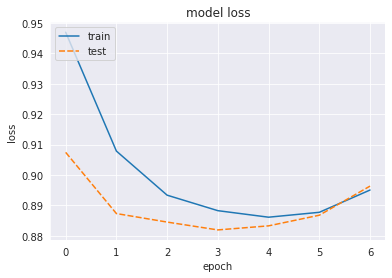

In [43]:
g = sns.lineplot(data=history_df)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
model.model.save(str(MODEL_DIR / "lstm_50dim_15-07.h5"))

In [45]:
model.attention_model.save(str(MODEL_DIR / "attention_lstm_50dim_15-07.h5"))

## Test model

In [46]:
with tf.device('GPU:0'):
    train_embeddings = model.model.predict(train_vectors)
    test_embeddings = model.model.predict(test_vectors)

In [47]:
test_embeddings.shape

(80724, 50)

In [55]:
with tf.device('CPU:0'):
    train_embeddings, train_attentions = model.attention_model.predict(train_vectors)
    test_embeddings, test_attentions = model.attention_model.predict(test_vectors)

In [56]:
test_attentions.shape

(80724, 150, 1)

In [57]:
test_embeddings.shape

(80724, 50)

### Clusterize

In [46]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

In [52]:
ratio = 0.1
print("Initial test shape: ", test_labels.shape[0])
clustering_vectors = test_embeddings[:int(test_embeddings.shape[0] * ratio)]
clustering_true_labels = test_labels[:int(test_labels.shape[0] * ratio)]
print("Vectors:", clustering_vectors.shape)

Initial test shape:  81430
Vectors: (8143, 50)


In [53]:
%%time
agg_cl = AgglomerativeClustering(affinity='euclidean', linkage='complete')
clusers_labels = agg_cl.fit_predict(clustering_vectors)

CPU times: user 2.74 s, sys: 258 ms, total: 3 s
Wall time: 3 s


In [55]:
adjusted_rand_score(clusers_labels, clustering_true_labels)

0.007703830233353039

### Classify

In [49]:
def compute_metrics(true_labels: List[int], 
                    pred_labels: List[int], 
                    labels: Optional[Union[str, int]]=None):
    
    print("***** Eval results {} *****")
    
    ac = accuracy_score(true_labels, pred_labels)
    bac = balanced_accuracy_score(true_labels, pred_labels)

    print('Accuracy score:', ac)
    print('Balanced_accuracy_score:', bac)
    if labels:
        print(classification_report(true_labels, pred_labels, labels=labels))
    else:
        print(classification_report(true_labels, pred_labels))

In [50]:
n_neighbors = 5
metric_name = 'cosine'

knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric_name, weights='distance')
knn = knn.fit(train_embeddings, train_labels)

In [51]:
test_preds = knn.predict(test_embeddings)
compute_metrics(test_labels, test_preds)

***** Eval results {} *****
Accuracy score: 0.49718794906099795
Balanced_accuracy_score: 0.14548638076899115
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.29      0.30      0.30       415
           2       0.50      0.10      0.17        10
           3       0.17      0.08      0.11        13
           4       0.11      0.07      0.08        92
           5       0.22      0.16      0.19        98
           6       0.12      0.08      0.10       118
           7       0.00      0.00      0.00        11
           8       0.43      0.50      0.46       441
           9       0.19      0.14      0.16       139
          10       0.00      0.00      0.00        11
          11       0.00      0.00      0.00        17
          12       0.34      0.11      0.17       106
          13       1.00      0.10      0.18        10
          14       0.00      0.00      0.00        39
          15       0.20   

## Triplets accuracy

In [52]:
Example = namedtuple("Example", ["guid", "data", "label"])
TripletExample = namedtuple("TripletExample", ["anchor", "positive", "negative", "label"])

def create_triplets(data: List[Example]) -> List[TripletExample]:
    """
    Create triplets for a [(label, data), (label, data)...] dataset
    by using each example as an anchor and selecting randomly a
    positive instance with the same label and a negative instance with a different label
    """
    triplets = []
    label2vec = defaultdict(list)
    # Collect by label
    for example in data:
        label2vec[example.label].append(example)
 
    for example in data:
        anchor = example
 
        if len(label2vec[example.label]) < 2: #We need at least 2 examples per label to create a triplet
            continue
        # Positive example from the same label
        positive = None
        while positive is None or positive.guid == anchor.guid:
            positive = random.choice(label2vec[example.label])
        # Negative example from different label
        negative = None
        while negative is None or negative.label == anchor.label:
            negative = random.choice(data)
 
        triplets.append(TripletExample(anchor=anchor.data,
                                       positive=positive.data,
                                       negative=negative.data,
                                       label=anchor.label))
    return triplets

def wrap_dataset(data: np.ndarray, labels: np.ndarray) -> List[Example]:
    """
    Create dataset for a sequence of [(label, data), (label, data)...] samples.
    """
    return [Example(guid=i, data=d, label=l) for i, (d, l) in enumerate(zip(data, labels))]

In [53]:
test_triplets = create_triplets(wrap_dataset(test_embeddings, test_labels))
print(f"Triplets Dataset length: {len(test_triplets)}")

Triplets Dataset length: 80724


In [54]:
testing_margin = 0.2
n_correct_triplets = 0

for i, triplet in enumerate(test_triplets):
    if (cosine(triplet.anchor, triplet.negative)) - (cosine(triplet.anchor, triplet.positive)) > testing_margin:
        n_correct_triplets += 1
        
accuracy = n_correct_triplets / len(test_triplets)
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.779


### On stemming

### On lemmas

# Keywords

In [ ]:
client_pattern = re.compile(f"(client:)([А-Яа-яЁё#\s]+)(operator:)?")
operator_pattern = re.compile(f"(operator:)([А-Яа-яЁё#\s]+)(client:)?")

def select_role_speech(df: pd.DataFrame, msg_col: str, role: str):
    if role == 'client':
        df['client_msg'] = df[msg_col].apply(lambda x: " ".join([i[1].strip() for i in client_pattern.findall(x)])
                                            if "client" in x else "") 
    else:
        df['operator_msg'] = df[msg_col].apply(lambda x: " ".join([i[1].strip() for i in operator_pattern.findall(x)])
                                              if "operator" in x else "")
    return df

In [117]:
def add_attention_to_df(df: pd.DataFrame, attention_vecs: np.ndarray, 
                        indexes: np.ndarray) -> pd.DataFrame:
    df['attention'] = None
    for i, att in zip(indexes, attention_vecs):
        df.at[i, 'attention'] = att
    return df

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"From Train {train_df.shape[0]}, has vectors {train_df.iloc[train_indexes].shape[0]}, difference: {train_df.shape[0] - train_df.iloc[train_indexes].shape[0]}")
print(f"From Test {test_df.shape[0]}, has vectors {test_df.iloc[test_indexes].shape[0]}, difference: {test_df.shape[0] - test_df.iloc[test_indexes].shape[0]}")

train_df = add_attention_to_df(train_df, train_attentions, train_indexes)
test_df = add_attention_to_df(test_df, test_attentions, test_indexes)
print("Train without attention:", train_df.attention.isna().sum())
print("Test without attention:", test_df.attention.isna().sum())

From Train 330766, has vectors 313821, difference: 16945
From Test 85054, has vectors 80724, difference: 4330
Train without attention: 16945
Test without attention: 4330


In [149]:
train_df_att = dvect.devectorize_df(train_df, 'client_msg_vector', 'tokens', padding_value=0)
test_df_att = dvect.devectorize_df(test_df, 'client_msg_vector', 'tokens', padding_value=0)
train_df_att.head(2)

  0%|          | 0/1 [37:09<?, ?it/s]
Exception ignored in: <bound method tqdm.__del__ of <tqdm.std.tqdm object at 0x7f5792ac3ba8>>
Traceback (most recent call last):
  File "/opt/app-root/lib/python3.6/site-packages/tqdm/std.py", line 1152, in __del__
    self.close()
  File "/opt/app-root/lib/python3.6/site-packages/tqdm/std.py", line 1271, in close
    if self.disable:
AttributeError: 'tqdm' object has no attribute 'disable'


,req_num,req_reg_datetime,msg,product,subject,s_subject,subproduct,client_msg_vector,vector_update_datetime,label_name,label,attention,tokens
0,2101070164160500,2021-01-07 13:43:46,operator: #ФИО здравствуйте operator:и вас с ...,Банковская карта,На карту Сбербанка,"Комиссии, сроки, условия",Перевод (от ФЛ к ФЛ),"[284.0, 99.0, 284.0, 7.0, 17.0, 39.0, 3331.0, ...",12:50:28.455658,"Банковская карта : Комиссии, сроки, условия",48,"[[0.00022447215], [0.00050443213], [0.00026666...","[праздник, день, праздник, сказать, хотеть, пе..."
1,2101040980953500,2021-01-04 10:39:27,operator:здравствуйте client:здравствуйте мне ...,Банковская карта,Предоставление информации,Статус БК/Порядок предоставления документов,Дебетовая карта,"[1.0, 61.0, 236.0, 153.0, 656.0, 41070.0, 165....",12:50:28.455658,Банковская карта : Статус БК/Порядок предостав...,100,"[[0.00033805988], [0.0024606152], [0.001015593...","[карта, разблокировать, давать_проверить, возм..."


In [189]:
# View attention <--> words pairs
scored_texts = []
for i, (att, wrds) in enumerate(zip(test_df_att['attention'].dropna().apply(lambda x: x.reshape(-1).tolist()).to_list(),
                          test_df_att['tokens'].dropna().to_list())):   
    scored_texts.append({w: a for w, a in zip(wrds, att)})


print(len(scored_texts))

80724


In [194]:
test_df_att['msg'][2], test_df_att['label_name'][2]

('operator: #ФИО  здравствуйте client:здравствуйте девушка у меня такой вопрос я пытался перевести сумму сто  #ЧИСЛО   #ЧИСЛО  тысяч client:вот а мне запрещают ее переводить operator: #ФИО   #ФИО  вас требует подтверждения client:ну как подтверждение там лицом я фотографировался client:голосовое подтверждение все сказал все равно запрещают типа махинации какие то operator:так одна минута client:а оплатить можно operator:спасибо за ожидание я проверил информацию значит работа сбербанк онлайн сейчас приостановлено наш сотрудник свяжется с вами в ближайшее время для разблокировки доступа в личный кабинет вам необходимо будет дождаться звонка и после этого вы сможете работать в личном кабинете client:ну блин ну понимаете мне деньги надо сейчас перевести там может на операцию отправить деньги operator:я понимаю но к сожалению я разблокировать не смогу это только на исходящем звонке я вам должен позвонить сотрудник банка client:замечательно спасибо девушка operator:да не за что всего хорошег

In [195]:
sorted(scored_texts[2].items(), key=lambda x: -x[1])

[('разблокировка_доступ', 0.32091280817985535),
 ('дождаться_звонок', 0.10068386048078537),
 ('близкий_время', 0.038663335144519806),
 ('связаться', 0.0365888886153698),
 ('фотографироваться', 0.034667424857616425),
 ('исходящий_звонок', 0.03249739855527878),
 ('голосовой_подтверждение', 0.024939369410276413),
 ('наш_сотрудник', 0.02305242419242859),
 ('сотрудник_банк', 0.014191335067152977),
 ('махинация', 0.012286397628486156),
 ('лицо', 0.010402563028037548),
 ('запрещать', 0.007487892638891935),
 ('минута', 0.006180752068758011),
 ('свидание', 0.006024944595992565),
 ('работать', 0.00585832679644227),
 ('оплатить', 0.00577946612611413),
 ('проверить_информация', 0.00576845882460475),
 ('личный_кабинет', 0.004828625358641148),
 ('оценить', 0.004494155757129192),
 ('требовать_подтверждение', 0.0033382843248546124),
 ('свидание_свидание', 0.0028402814641594887),
 ('весь_хороший', 0.0026575124356895685),
 ('двоечка', 0.0023872924502938986),
 ('замечательный', 0.0023000906221568584),
 (